LOADING AND EXTRACTING DATA

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def load_data():
    
    # Load dataset file
    train_df = pd.read_csv('../data/training.csv')
    
    train_df.drop(['nose_tip_x','nose_tip_y'], axis=1, inplace=True)
    
    train_df['Image'] = train_df['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    train_df = train_df.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    array_imgs = np.vstack(train_df['Image'].values)/ 255.0
    array_imgs = array_imgs.astype(np.float32)    # Normalize, target values to (0, 1)
    array_imgs = array_imgs.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    array_labels = train_df[train_df.columns[:-1]].values
    array_labels = (array_labels - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    array_labels = array_labels.astype(np.float32) 
    
    # shuffle the train data
#     array_imgs, array_labels = shuffle(array_imgs, array_labels, random_state=9)  
    
    return array_imgs, array_labels


VERIFY TRAINING DATA

(2140, 96, 96, 1)
(2140, 28)


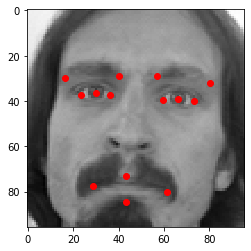

In [2]:
imgs, labels = load_data()
print(imgs.shape)
print(labels.shape)

n=0
labels[n] = (labels[n]*48)+48
image = np.squeeze(imgs[n])
plt.imshow(image, cmap='gray')
plt.plot(labels[n][::2], labels[n][1::2], 'ro')
plt.show()
    

BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
# from keras.optimizers import Adam


# Main model
def cnn_model():
    cnn_model = Sequential()
    
    cnn_model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    cnn_model.add(MaxPooling2D(pool_size=2))
    
    cnn_model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=2))
    
    cnn_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=2))
    
    cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=2))
    
    cnn_model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    cnn_model.add(Flatten())
    
    cnn_model.add(Dense(512, activation='relu'))
    cnn_model.add(Dropout(0.2))

    cnn_model.add(Dense(28))
    
    return cnn_model


X_train, y_train = load_data()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 60
batch_size = 64

model = cnn_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='../model/checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('../model/model1.h5')

Using TensorFlow backend.


Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 28)
Train on 1712 samples, validate on 428 samples
Epoch 1/60
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0536 - accuracy: 0.3867 - val_loss: 0.0142 - val_accuracy: 0.4322

Epoch 00001: val_loss improved from inf to 0.01424, saving model to ../model/checkpoint1.hdf5
Epoch 2/60
1712/1712 [==============================] - 8s 5ms/step - loss: 0.0094 - accuracy: 0.6893 - val_loss: 0.0079 - val_accuracy: 0.4322

Epoch 00002: val_loss improved from 0.01424 to 0.00788, saving model to ../model/checkpoint1.hdf5
Epoch 3/60
1712/1712 [==============================] - 8s 5ms/step - loss: 0.0066 - accuracy: 0.6805 - val_loss: 0.0076 - val_accuracy: 0.4322

Epoch 00003: val_loss improved from 0.00788 to 0.00764, saving model to ../model/checkpoint1.hdf5
Epoch 4/60
1712/1712 [==============================] - 8s 5ms/step - loss: 0.0059 - accuracy: 0.6986 - val_loss: 0.0078 

PLOT MODEL ACCURACY THROUGH EACH EPOCH

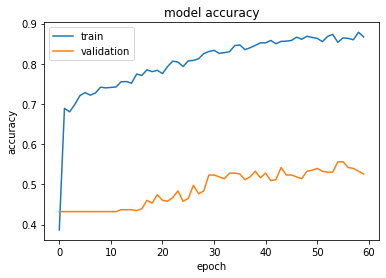

In [4]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

PLOT MODEL LOSS THROUGH EACH EPOCH

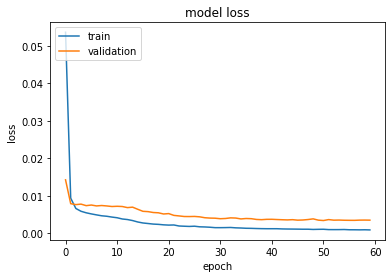

In [5]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()